# Arctic Wave Watch 3 files

* **Description**: Creates file of Utqiagvik data from CESM2-LE
* **Input data**: CESM2-le daily timeseries data
* **Output data**: Netcdf with data
* **Creator**: Alice DuVivier
* **Date**: December 2025

### Import Packages

In [1]:
#import utils
import xarray as xr
import numpy as np
from glob import glob
import importlib
from datetime import datetime
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cmocean
import pandas as pd

## Find point nearest Utqiagvik

In [2]:
# set latitude and longitude of Village (longitudes must be in 0-360)
name_village = 'Utqiagvik'
lat_village = 71.29
lon_village = 203.21
#longitue = -156.79

In [3]:
# set a dataset to read in to get grid information - using grid file that Frank Bryan made and provided
dir_in = '/glade/u/home/duvivier/masks/'
file_in = 'ww3.4x3.grid.nc'
ds = xr.open_dataset(dir_in+file_in, decode_times=False)

In [4]:
# grab lat and lon data
lat1d = ds.lat
lon1d = ds.lon
land = ds.mask

#create a meshgrid (2D fields of lats and lons)
lon2d,lat2d=np.meshgrid(lon1d,lat1d)

In [5]:
# First, find the index of the grid point nearest a specific lat/lon.   
abslat = np.abs(lat1d - lat_village)
abslon = np.abs(lon1d - lon_village)
c = np.maximum(abslon, abslat)

# find the smallest values
([xloc], [yloc]) = np.where(c == np.min(c))

# print index values
print(xloc,yloc)

51 47


In [6]:
# Check how close these are to the latitude and longitude of the village
print(name_village+': '+str(lat_village)+','+str(lon_village))

lat_grid = lat1d.isel(lat=yloc).values
lon_grid = lon1d.isel(lon=xloc).values
print('grid point: '+str(lat_grid)+','+str(lon_grid))

Utqiagvik: 71.29,203.21
grid point: 72.00000762939453,204.0


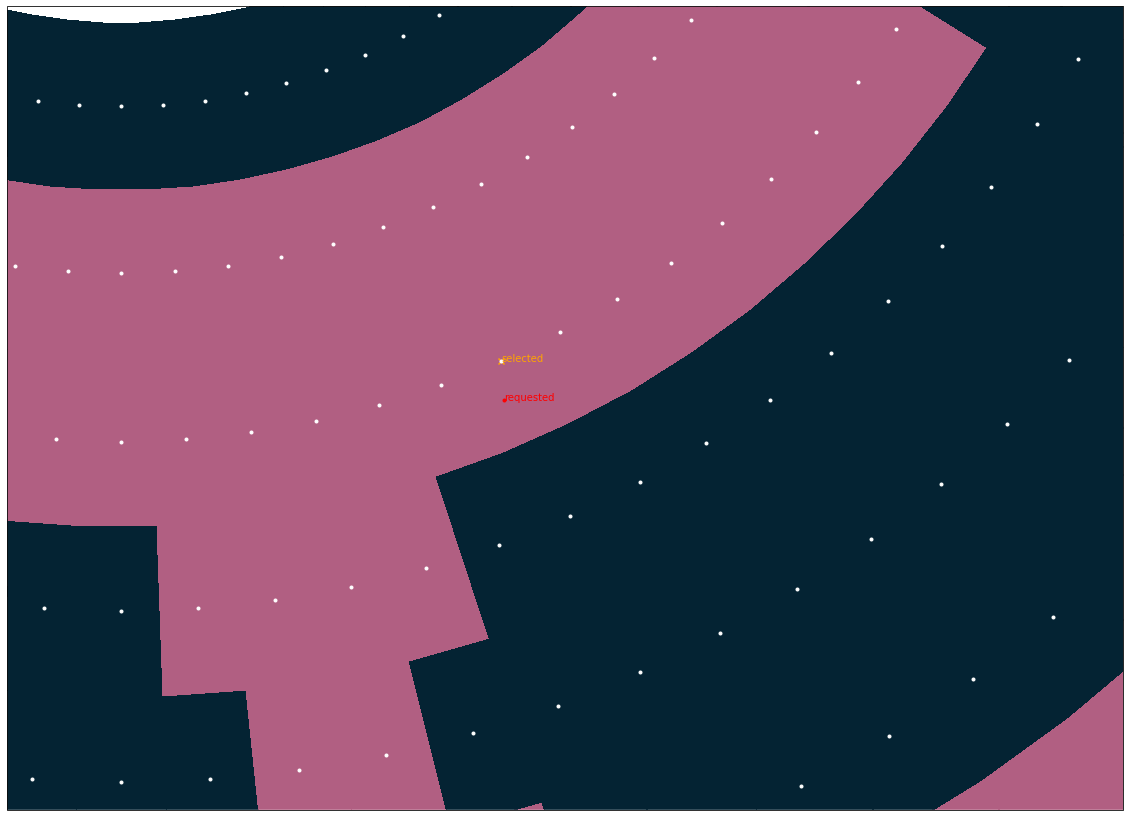

In [7]:
# Plot the Grid points to ensure we have the closest point for plots
fig = plt.figure(figsize=(20,20))

# make plot
ax = plt.subplot(1,1,1)
ax = plt.subplot(1,1,1,projection = ccrs.NorthPolarStereo(central_longitude=180.0) )
#ax.set_extent([-140, -179, 72, 69], crs=ccrs.PlateCarree())
ax.set_extent([-130, -185, 75, 65], crs=ccrs.PlateCarree())

# do a pcolormesh plot of input
cs0 = ax.pcolormesh(lon1d, lat1d,
                    land,
                    cmap = cmocean.cm.thermal, vmin = 0, vmax = 2,
                    transform=ccrs.PlateCarree())

# do scatter plot of all grid values
cs1 = ax.plot(lon2d, lat2d, land,
              c='white',marker='.', linestyle='none',
              transform=ccrs.PlateCarree())                 

# Plot requested lat/lon point
cs2 = ax.scatter(lon_village, lat_village, marker='.',c='red', transform=ccrs.PlateCarree())
tx1 = ax.text(lon_village, lat_village, 'requested', c='red', transform=ccrs.PlateCarree())

# Plot nearest point in the array red
cs4 = plt.scatter(lon1d.isel(lon=xloc), lat1d.isel(lat=yloc), marker='x', color='orange', transform=ccrs.PlateCarree())
tx2 = plt.text(lon1d.isel(lon=xloc), lat1d.isel(lat=yloc), 'selected', c='orange', transform=ccrs.PlateCarree())
               

- This point is an ocean point and is closest to the Utqiagvik village. Proceed!

In [8]:
# print original index values
print(xloc,yloc)

51 47


## Read in 8 CESM-LE ensemble members that have WW3 data and are consistent

In [13]:
# Set Path to the files files
path = '/glade/campaign/cgd/ppc/duvivier/arctic_actionable/DATA/cesm2-le_ww3_fullgrid/'

In [14]:
# list the cesm2-le members with this data
ens_mems = ['001', '002', '003',
            '004', '005', '006',
            '007', '008']

### Load historical data

In [15]:
%%time

print('loading historical data')
ds_hist = xr.Dataset()

for m in ens_mems:
    print(m)
    # set ensemble name
    case = 'b.e21.BHISTcmip6.f09_g17.LE2-1231.' + m
    # get a list of the files
    files = sorted(glob(f'{path}/historical/{case}.ww3.hi.????-????.nc'))
    # load these files in
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, 
                               concat_dim="record", combine='nested', decode_times=True)

    # concatenate into the historical array
    ds_hist = xr.concat([ds_hist,ds_tmp], dim='member_id')


loading historical data
001
002
003
004
005
006
007
008
CPU times: user 277 ms, sys: 42.8 ms, total: 320 ms
Wall time: 1.35 s


In [16]:
# make the record dimension into a useful time dimension
ds_hist = ds_hist.rename({'record': 'time'})

# create a new date array
dates = pd.date_range(start="1990-09-01", end="2014-12-31", freq="6h")

# now drop non autumn (SON) months
months_to_drop = [1,2,3,4,5,6,7,8,12]
mask = ~dates.month.isin(months_to_drop)
dates_sub = dates[mask]

# assign these dates as a time array to the data
ds_hist['time'] = dates_sub

### Load future data

In [17]:
%%time

print('loading historical data')
ds_ssp = xr.Dataset()

for m in ens_mems:
    print(m)
    # set ensemble name
    case = 'b.e21.BSSP370cmip6.f09_g17.LE2-1231.' + m
    # get a list of the files
    files = sorted(glob(f'{path}/future/{case}.ww3.hi.????-????.nc'))
    # load these files in
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, 
                               concat_dim="record", combine='nested', decode_times=True)

    # concatenate into the historical array
    ds_ssp = xr.concat([ds_ssp,ds_tmp], dim='member_id')


loading historical data
001
002
003
004
005
006
007
008
CPU times: user 473 ms, sys: 150 ms, total: 623 ms
Wall time: 4.47 s


In [18]:
# make the record dimension into a useful time dimension
ds_ssp = ds_ssp.rename({'record': 'time'})

# create a new date array
dates = pd.date_range(start="2015-09-01", end="2099-12-31", freq="6h")

# now drop non autumn (SON) months
months_to_drop = [1,2,3,4,5,6,7,8,12]
mask = ~dates.month.isin(months_to_drop)
dates_sub = dates[mask]

# assign these dates as a time array to the data
ds_ssp['time'] = dates_sub

## Concatenate historical and future datasets

In [21]:
ds = xr.concat((ds_hist,ds_ssp),dim='time')

In [22]:
ds

,Array,Chunk
Bytes,5.37 GiB,62.48 MiB
Shape,"(8, 40040, 50, 90)","(1, 3640, 50, 90)"
Count,900 Tasks,96 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,5.37 GiB,62.48 MiB
Shape,"(8, 40040, 50, 90)","(1, 3640, 50, 90)"
Count,900 Tasks,96 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [23]:
# keep only the point we're interested in near village
ds_subset = ds.isel(NY=slice(yloc,yloc+1),NX=slice(xloc,xloc+1))

In [24]:
# drop extra dimensions and keep only the significant wave height (HS)
ds_subset = ds_subset.HS.isel(NY=0,NX=0)

In [25]:
ds_subset

<xarray.DataArray 'HS' (member_id: 8, time: 40040)>
dask.array<getitem, shape=(8, 40040), dtype=float32, chunksize=(1, 3640), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1990-09-01 ... 2099-11-30T18:00:00
Dimensions without coordinates: member_id
Attributes:
    units:      m
    long_name:  Significant wave height

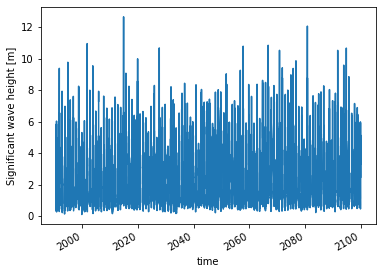

In [26]:
ds_subset.isel(member_id=0).plot()

In [27]:
%%time
ds_subset.load()

CPU times: user 3.53 s, sys: 7.2 s, total: 10.7 s
Wall time: 49.3 s


<xarray.DataArray 'HS' (member_id: 8, time: 40040)>
array([[2.525025  , 2.0094702 , 1.7017518 , ..., 4.401583  , 3.84041   ,
        3.3149042 ],
       [1.1373134 , 1.3877414 , 1.6146244 , ..., 1.5145805 , 1.2586758 ,
        1.197636  ],
       [3.825935  , 3.7657032 , 3.3581655 , ..., 1.9273288 , 3.155558  ,
        4.9587803 ],
       ...,
       [2.0638816 , 2.1128366 , 2.1402872 , ..., 0.87645745, 0.7548972 ,
        0.7081031 ],
       [1.4623284 , 1.2173847 , 1.0054362 , ..., 1.4745632 , 1.1711569 ,
        1.0092257 ],
       [1.546654  , 1.3817285 , 1.2526941 , ..., 1.0516059 , 1.0264275 ,
        0.98953295]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1990-09-01 ... 2099-11-30T18:00:00
Dimensions without coordinates: member_id
Attributes:
    units:      m
    long_name:  Significant wave height

## Save the variable
- Netcdf with variable dimension: (member_id x time)
- One netcdf per variable

In [28]:
ds_out = xr.Dataset()

ds_out['HS'] = ds_subset

# change the attributes
ds_out.attrs['author'] = 'Alice DuVivier'
ds_out.attrs['date_processed'] = datetime.now().strftime('%Y-%m-%d')
ds_out.attrs['contents'] = f'6H CESM2-LE WW3 data for ocean point nearest Utqiagvik - subset of ensemble members'

ds_out

<xarray.Dataset>
Dimensions:  (time: 40040, member_id: 8)
Coordinates:
  * time     (time) datetime64[ns] 1990-09-01 ... 2099-11-30T18:00:00
Dimensions without coordinates: member_id
Data variables:
    HS       (member_id, time) float32 2.525 2.009 1.702 ... 1.052 1.026 0.9895
Attributes:
    author:          Alice DuVivier
    date_processed:  2025-12-10
    contents:        6H CESM2-LE WW3 data for ocean point nearest Utqiagvik -...

In [29]:
# Print the dimensions
print("Dimensions:")
for dim in ds_out.dims:
    print(f"\t{dim}: {ds_out[dim].values.shape}")

# Print the coordinates
print("Coordinates:")
for coord in ds_out.coords:
    print(f"\t{coord}:")
    print(f"\t\t{ds_out.coords[coord].values}")
    
# Print the attributes
print("Attributes:")
for attr in ds_out.attrs:
    print(f"\t{attr}: {ds_out.attrs[attr]}")
    

Dimensions:
	time: (40040,)
	member_id: (8,)
Coordinates:
	time:
		['1990-09-01T00:00:00.000000000' '1990-09-01T06:00:00.000000000'
 '1990-09-01T12:00:00.000000000' ... '2099-11-30T06:00:00.000000000'
 '2099-11-30T12:00:00.000000000' '2099-11-30T18:00:00.000000000']
Attributes:
	author: Alice DuVivier
	date_processed: 2025-12-10
	contents: 6H CESM2-LE WW3 data for ocean point nearest Utqiagvik - subset of ensemble members


## Export and Save

In [30]:
# calculate the size of the dataset in GB
size_gb = ds_out.nbytes / (1024**3)
print(f"The dataset is approximately {size_gb:.2f} GB.")


The dataset is approximately 0.00 GB.


In [31]:
path_out = '/glade/campaign/cgd/ppc/duvivier/arctic_actionable/DATA/cesm2-le_utqiagvik/'
file_out = name_village+'_CESM2-LE_1990-2100_6H-HS.nc'
fout = path_out + file_out
print(fout)

/glade/campaign/cgd/ppc/duvivier/arctic_actionable/DATA/cesm2-le_utqiagvik/Utqiagvik_CESM2-LE_1990-2100_6H-HS.nc


In [32]:
# Export the dataset to NetCDF with all attributes and coordinates
ds_out.to_netcdf(fout)